# Neural CA

In this notebook you can train a CA that converges to a given image, like in the Growing Neural Cellular Automata paper

In [1]:
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms as T

import pylab as pl

from src import *

In [2]:
N_CHANNELS = 16        # Number of CA state channels
TARGET_PADDING = 8    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
N_ITERS = 50

torch.backends.cudnn.benchmark = True  # Speeds up training

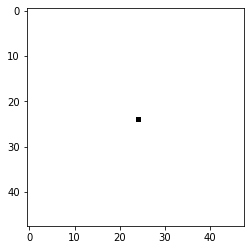

In [3]:
# Starting state

def generator(n, device):
    return make_seed(n, N_CHANNELS-1, IMAGE_SIZE, alpha_channel=3, device=device)

pool = SamplePool(POOL_SIZE, generator)
imshow(pool[0])

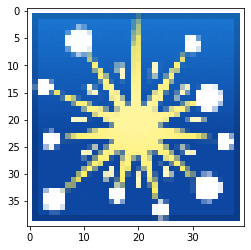

In [4]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [5]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

target = target.to(device)
model = NeuralCA(N_CHANNELS, device)

In [6]:
# Load a pretrained model
model.load("Pretrained_models/firework_regenerating.pt")

Successfully loaded model!


## Train the model

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
criterion = NCALoss(pad(target, TARGET_PADDING), torch.nn.MSELoss)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40, 80], gamma=0.3)

# Change kind in "growing" to train for growing, "persistent" to train for persistence
#model.train_CA(optimizer, criterion, pool, batch_size=8, n_epochs=300, scheduler=scheduler, kind="regenerating", skip_damage=2)

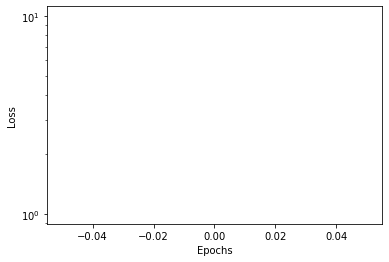

In [8]:
# Plot the losses
model.plot_losses()

In [ ]:
# Save a model
model.save("my_model.pt")

In [12]:
# Make evolution video
video, last_frame = make_video(model, n_iters=120, fps=10, fname="my_video.mp4")

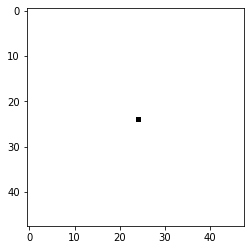

In [16]:
# A damaged image
image = pool.sample(1)[0]
imshow(image[0])

/home/lettera/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([4, 48, 48])) that is different to the input size (torch.Size([1, 4, 48, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loss:  (tensor(0.0007, device='cuda:0'), [0])


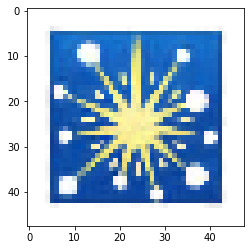

In [19]:
# After 200 iters the CA perfectly corrects it
x = model.evolve(image.cuda(), 200)
print("loss: ", criterion(x))
imshow(x[0])